<b> Import Library, find available devices </b>

In [ ]:
# Initialization code for Beta Multiplier Reference Testing.
# This block identifies and initializes the connected SMUs (Source Measure Units).
# If running for the first time, ensure the SMU names are correctly referenced in the subsequent code block.

# This program (ENTER DESCRIPTION)
# This program 
# This program creates a .csv file to save the measurements.

# The setup assumes the use of three SMUs:
# - 
# - 

import pyvisa                    # Importing the pyvisa library for instrument communication
import time                      # Importing the time module to handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting graphs and visualizing data
import numpy as np               # Importing numpy for numerical operations, particularly with arrays
import pandas as dp              # Importing pandas as dp for data manipulation and analysis
import os                        # Importing os to interact with the operating system, such as handling file paths
import csv                       # Importing csv to read from and write to CSV files
from datetime import date           # Importing date to read current date
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

In [ ]:
#Establishing Connection for DUT 1 SMU
SM1 = rm.open_resource('GPIB6::20::INSTR')  # Open a connection to the instrument with the address 'ASRL3::INSTR' and assign it to SM_VIN
SM1.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
SM1.write_termination = '\n'            # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
SM1.baud_rate = 9600                    # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
print(SM1)                              # Print the resource object (SM_VIN) to display its properties
print(SM1.query('*IDN?'))               # Send the '*IDN?' command to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).

#Establishing Connection for DUT 2 SMU
SM2 = rm.open_resource('GPIB6::21::INSTR') # Open a connection to the instrument with the address 'ASRL4::INSTR' and assign it to SM_VOUT
SM2.read_termination = '\n'            # Set the read termination character to a newline for SM_VOUT, similar to SM_VIN
SM2.write_termination = '\n'           # Set the write termination character to a newline for SM_VOUT, similar to SM_VIN
SM2.baud_rate = 9600                   # Set the baud rate for SM_VOUT to 9600, ensuring both instruments communicate at the same speed
print(SM2)                             # Print the resource object (SM_VOUT) to display its properties
print(SM2.query('*IDN?'))              # Send the '*IDN?' command to the SM_VOUT instrument and print its response, identifying the instrument


#Establishing Connection for multimeter 1
MM1 = rm.open_resource('USB0::0x2A8D::0x0101::MY54505624::INSTR')
MM1.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM1.write_termination = '\n'
MM1.baud_rate = 9600
print(MM1)                             # Print the resource object (SM_VOUT) to display its properties
print(MM1.query('*IDN?'))   

#Establishing Connection for multimeter 2
MM2 = rm.open_resource('USB0::10893::257::MY57508183::0::INSTR')
MM2.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM2.write_termination = '\n'
MM2.baud_rate = 9600
print(MM2)                             # Print the resource object (SM_VOUT) to display its properties
print(MM2.query('*IDN?'))   


#Establishing Connection for Temperature Chamber
CHAMBER = rm.open_resource('GPIB6::6::INSTR') 
CHAMBER.read_termination = '\n'            
CHAMBER.write_termination = '\n'           
CHAMBER.baud_rate = 9600                  
print(CHAMBER)                            
print(CHAMBER.query('STATUS?'))              

VDD_MAX=1.2
currentRange = 1e-4

TEMPlist = [125, 100, 75, 50, 25, 0, -25, -50, -75, -100, -125, -150, -175]      # List of temperatures for test

<b> Enter the Device under Test <b>

In [ ]:
directory_name = input("Enter the Device under Test (DUT):")  # Prompt the user to input the temperature of the experiment, which will be used as the directory name
DUT="DUT_"+str(directory_name)                                # DUT_"directory_name"
os.makedirs(DUT, exist_ok=True)                             # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True
DATE=str(DUT)+"/"+str(date.today())                         # Create another directory for test date within DUT name.  DUT_"directory_name"/yyyy-mm-dd
os.makedirs(DATE, exist_ok=True) 

<b> Test Sweep Definitions </b>

In [ ]:
def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))
    return




#Current scaling function to determine the appropriate scaling for the y-axis of the generated plots
def IScale(Iarray):
    
    if np.max(np.abs(Iarray)) < 1e-9:
        k = 1e12
        Iunit = 'pA' # picoamps

    elif np.max(np.abs(Iarray)) < 1e-6:
        k = 1e9
        Iunit = 'nA' # nanoamps

    elif np.max(np.abs(Iarray)) <= 1e-3:
        k = 1e6
        Iunit = 'µA' # microamps

    elif np.max(np.abs(Iarray)) < 1:
        k = 1e3
        Iunit = 'mA' # milliamps

    else:
        k = 1
        Iunit = 'A' # amps

    # Scale the current values based on the determined scaling factor
    scaled_current = k*Iarray
    
    # Return the scaled current values and the corresponding unit for the y-axis
    return scaled_current, Iunit 




In [ ]:
SM1.write(":CONF:CURR")                  # Configure the SMU to measure current
SM1.write("OUTP:STAT 0")                 # Turn off the VIN source meter
print(SM1.query(":CONF?"))               # Query and print the current configuration of the SMU
SM1.write("SOUR:VOLT:RANG 3.3")
SM1.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
SM1.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
SM1.write("CURR:NPLC .01")

SM2.write(":CONF:CURR")                  # Configure the SMU to measure current
SM2.write("OUTP:STAT 0")                 # Turn off the VIN source meter
print(SM2.query(":CONF?"))               # Query and print the current configuration of the SMU
SM2.write("SOUR:VOLT:RANG 3.3")
SM2.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
SM2.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
SM2.write("CURR:NPLC .01")




points=[]
points2=[]
for x in range(500):
    points.append(x)
    points2.append(x*1000)
#M2plot = plt.subplots(layout='constrained')
M2plot = plt.plot(points, points2)
#M2plot.plot(points, points2)

In [226]:
MM1.write("ABOR")
MM1.write("*RST; *CLS")
MM1.write(":CONF:VOLT:DC")
MM1.write("VOLT:NPLC .02")
MM1.write("VOLT:DC:RANG 2")
MM1.write("VOLT:DC:ZERO:AUTO OFF")

MM2.write("ABOR")
MM2.write("*RST; *CLS")
MM2.write(":CONF:VOLT:DC")
MM2.write("VOLT:NPLC .02")
MM2.write("VOLT:DC:RANG 2")
MM2.write("VOLT:DC:ZERO:AUTO OFF")


y1=[]
y2=[]
x=np.arange(0, 1.21, 0.01)
SM1.write("OUTP:STAT 1")     
SM2.write("OUTP:STAT 1")

12

In [227]:
for i in range (121):        # Loop from VIN_MAX to VIN_MIN in steps of VIN_STEP                                                            
    val = i / 100                                        # Convert the current loop index into a floating-point voltage value
    ############ Sets VIN voltage ############                
    SM1.write("SOUR:VOLT:LEV " + str(val))          # Write the command to set the VIN voltage on the source meter        
    SM2.write("SOUR:VOLT:LEV " + str(val))                                      # Pause for .5 seconds to allow the system to stabilize
    #time.sleep(.05)
    ######## Measure ILOAD and others ########
    
    #MM1.write("*TRG")
    #time.sleep(.05)
    y1.append(MM1.query(":READ?"))
    y2.append(MM2.query(":READ?"))
#y1=MM1.query("FETC?").split(',')
SM1.write("SOUR:VOLT:LEV 0")          # Write the command to set the VIN voltage on the source meter        
SM2.write("SOUR:VOLT:LEV 0")



16

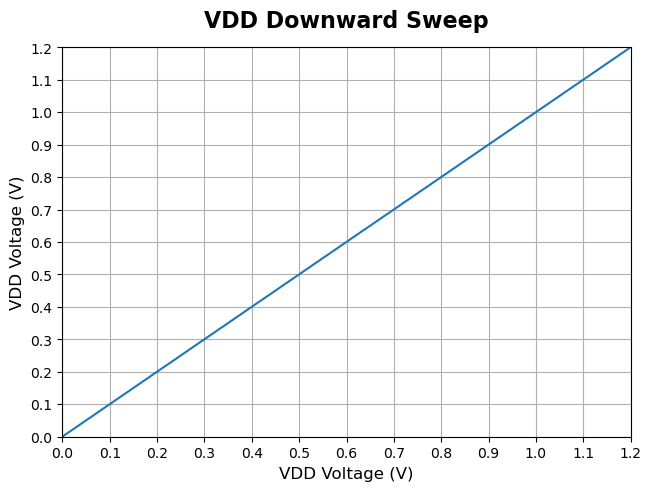

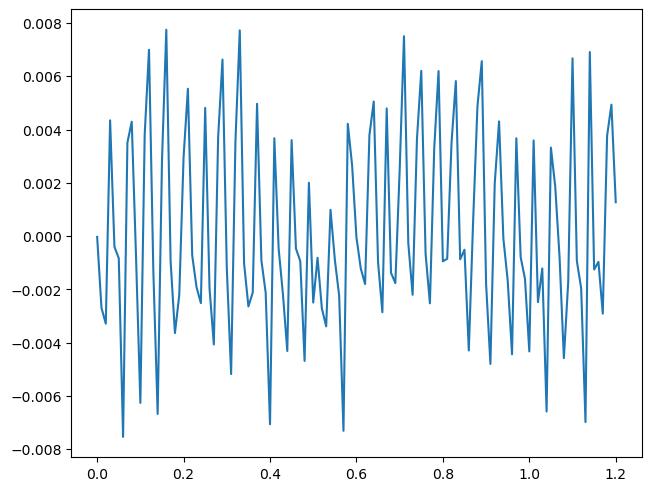

In [228]:
pddfig, M1plot = plt.subplots(layout='constrained')
pddfig, M2plot = plt.subplots(layout='constrained')
M1plot.set_title('VDD Downward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
M1plot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
M1plot.set_ylabel('VDD Voltage (V)', fontdict={'fontsize': 12})
M1plot.set_yticks(np.arange(0, 1.3, 0.1))
M1plot.set_xticks(np.arange(0, 1.3, 0.1))
M1plot.tick_params(axis='both', which='major', labelsize=10)
M1plot.set_xlim(0, 1.2)
M1plot.set_ylim(0, 1.2)
M1plot.grid()

M1plot.plot(x, np.asarray(y1, dtype='float'))
M2plot.plot(x, np.asarray(y2, dtype='float'))
#plt.close()
#M3plot = plt.plot(x, y2) 

<b> Example Sweep (w/o Temp Chamber) <b>

In [ ]:
cm=plt.get_cmap('gist_rainbow')

iddfig, IDDplot = plt.subplots(layout='constrained')
IDDplot.set_title('VDD Downward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDDplot.set_xticks(np.arange(0, 1.3, 0.1))
IDDplot.tick_params(axis='both', which='major', labelsize=10)
IDDplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
IDDplot.set_xlim(0, 1.2)
IDDplot.grid()

pddfig, PDDplot = plt.subplots(layout='constrained')
PDDplot.set_title('VDD Downward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDDplot.set_xticks(np.arange(0, 1.3, 0.1))
PDDplot.tick_params(axis='both', which='major', labelsize=10)
PDDplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PDDplot.set_xlim(0, 1.2)
PDDplot.grid()

idufig, IDUplot = plt.subplots(layout='constrained')
IDUplot.set_title('VDD Upward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDUplot.set_xticks(np.arange(0, 1.3, 0.1))
IDUplot.tick_params(axis='both', which='major', labelsize=10)
IDUplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
IDUplot.set_xlim(0, 1.2)
IDUplot.grid()

pdufig, PDUplot = plt.subplots(layout='constrained')
PDUplot.set_title('VDD Upward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDUplot.set_xticks(np.arange(0, 1.3, 0.1))
PDUplot.tick_params(axis='both', which='major', labelsize=10)
PDUplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PDUplot.set_xlim(0, 1.2)
PDUplot.grid()

pfig, PMOS = plt.subplots(layout='constrained')
PMOS.set_title('PMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PMOS.set_xlabel('PMOS Voltage (V)', fontdict={'fontsize': 12})
PMOS.set_xticks(np.arange(0, 1.3, 0.1))
PMOS.tick_params(axis='both', which='major', labelsize=10)
PMOS.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PMOS.set_xlim(0, 1.2)
PMOS.grid()

nfig, NMOS = plt.subplots(layout='constrained')
NMOS.set_title('NMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
NMOS.set_xlabel('NMOS Voltage (V)', fontdict={'fontsize': 12})
NMOS.set_xticks(np.arange(0, 1.3, 0.1))
NMOS.tick_params(axis='both', which='major', labelsize=10)
NMOS.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
NMOS.set_xlim(0, 1.2)
NMOS.grid()

for TEMP in TEMPlist:
#TEMP = 25       #Temporary temperature setting for room temperature testing
    local=str(DATE)+"/TEMP_"+str(TEMP)               # The temperature of the experiment gets set as the sub directory name. DUT_"directory_name"/yyyy-mm-dd/TEMP_"TEMP"
    os.makedirs(local, exist_ok=True)                # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True


    # Prevent annoying everyone while I'm testing (Must turn off beep after every reset in each sweep to keep it off)
    SM_NMOS.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the NMOS SMU
    SM_PMOS.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the PMOS SMU
    SM_VDD.write("SYST:BEEP:STAT OFF")            # Turn off the beeper on the VDD SMU


    VDD_INIT()
    NMOS_INIT()
    PMOS_INIT()

    NMOS_On()
    VDD_On()
    PMOS_On()

    time.sleep(2)

    #########################################################################
    ########################## VDD Downward Sweep ###########################
    #########################################################################
    VDDD, IDDD, PMOSID, = VDD_Sweep_Down(local)

    scaled_IDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
    IDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_IDD, label="T=" + str(TEMP) + " °C")
    IDDplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
    PDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PDDplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
    

    time.sleep(1)
    VDD_INIT()
    PMOS_INIT()
    time.sleep(1)

    #######################################################################
    ########################## VDD Upward Sweep ###########################
    #######################################################################
    VDDU, IDDU, PMOSIU, = VDD_Sweep_Up(local)

    scaled_IDD, Iunit = IScale(np.asarray(IDDU, dtype='float'))
    IDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_IDD, label="T=" + str(TEMP) + " °C")
    IDUplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
    PDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PDUplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

    #Generate VDD IV Plot for each temperature with upward & downward sweep on the same plot
    #Generate a VDD IV plot for a given temperature
    fig, VTEMP = plt.subplots(layout='constrained')
    scaled_IDDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
    scaled_IDDU, Iunit = IScale(np.asarray(IDDU, dtype='float'))
    VTEMP.set_title('VDD Sweep at T = ' + str(TEMP) + " °C", fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    VTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
    VTEMP.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
    VTEMP.set_xticks(np.arange(0, 1.3, 0.1))
    VTEMP.set_xlim(0, 1.2)
    VTEMP.tick_params(axis='both', which='major', labelsize=10)
    VTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_IDDD, label="Downward Sweep")
    VTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_IDDU, label="Upward Sweep")
    VTEMP.grid()
    VTEMP.legend()
    plt.close(fig)
    fig.savefig(os.path.join(local, "VDD_Sweep_IDD_T_" + str(TEMP) + ".png"))

    # Generate a VDD IV plot for a given temperature
    fig, PTEMP = plt.subplots(layout='constrained')
    scaled_PMOSID, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
    scaled_PMOSIU, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
    PTEMP.set_title('VDD Sweep at T = ' + str(TEMP) + " °C", fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    PTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
    PTEMP.set_ylabel('Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
    PTEMP.set_xticks(np.arange(0, 1.3, 0.1))
    PTEMP.set_xlim(0, 1.2)
    PTEMP.tick_params(axis='both', which='major', labelsize=10)
    PTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSID, label="Downward Sweep")
    PTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSIU, label="Upward Sweep")
    PTEMP.grid()
    PTEMP.legend()
    plt.close(fig)
    fig.savefig(os.path.join(local, "VDD_Sweep_PMOSI_T_" + str(TEMP) + ".png"))


    time.sleep(1)
    VDD_INIT()
    VDD_On()
    PMOS_INIT()
    PMOS_On()
    time.sleep(1)

    ################################################################
    ########################## PMOS Sweep ##########################
    ################################################################
    PMOSV, PMOSI = PMOS_Sweep(TEMP, local)
    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSI, dtype='float'))
    PMOS.plot(np.asarray(PMOSV, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PMOS.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


    time.sleep(1)
    PMOS_INIT()
    PMOS_On()
    time.sleep(1)

    ################################################################
    ########################## NMOS Sweep ##########################
    ################################################################
    NMOSV, NMOSI = NMOS_Sweep(TEMP, local)
    scaled_NMOSI, Iunit = IScale(np.asarray(NMOSI, dtype='float'))
    NMOS.plot(np.asarray(NMOSV, dtype='float'), scaled_NMOSI, label="T=" + str(TEMP) + " °C")
    NMOS.set_ylabel('NMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})



    time.sleep(1)
    NMOS_INIT()
    NMOS_On()
    time.sleep(1)

# Adjust the linewidth of the legend lines and legend location for each plot
for line in IDDplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PDDplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in IDUplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PDUplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PMOS.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in NMOS.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)

# Save the generated plots to the specified directory
iddfig.savefig(os.path.join(DATE, "VDD_Sweep_Down_IDD.png"))
pddfig.savefig(os.path.join(DATE, "VDD_Sweep_Down_PMOSI.png"))
idufig.savefig(os.path.join(DATE, "VDD_Sweep_Up_IDD.png"))
pdufig.savefig(os.path.join(DATE, "VDD_Sweep_Up_PMOSI.png"))
pfig.savefig(os.path.join(DATE, "PMOS_Sweep.png"))
nfig.savefig(os.path.join(DATE, "NMOS_Sweep.png"))

# Turn off the SMUs
SM_PMOS.write("OUTP:STAT 0")
SM_NMOS.write("OUTP:STAT 0") 
SM_VDD.write("OUTP:STAT 0")


In [ ]:
VDD_INIT()
NMOS_INIT()
PMOS_INIT()

NMOS_On()
VDD_On()
PMOS_On()

###############################################################
##################### VDD Downward Sweep ######################
###############################################################
VDD_Sweep_Down()
time.sleep(1)
VDD_INIT()
PMOS_INIT()
time.sleep(1)
###############################################################
##################### VDD Upwnward Sweep ######################
###############################################################
VDD_Sweep_Up()
time.sleep(1)
VDD_INIT()
VDD_On()
PMOS_INIT()
PMOS_On()
time.sleep(1)
######################################################
##################### PMOS Sweep #####################
######################################################
PMOS_Sweep()
time.sleep(1)
PMOS_INIT()
PMOS_On()
time.sleep(1)
######################################################
##################### NMOS Sweep #####################
######################################################
NMOS_Sweep()
time.sleep(1)
NMOS_INIT()
NMOS_On()
time.sleep(1)

<b> Test Protocol </b>

In [ ]:
################## Initial creation and format of overall IV curves ##################
# Create a color map for the plots
cm=plt.get_cmap('gist_rainbow')

# Create a figure for the overall IDD plot for the VDD Downward Sweep
iddfig, IDDplot = plt.subplots(layout='constrained')
IDDplot.set_title('VDD Downward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDDplot.set_xticks(np.arange(0, 1.3, 0.1))
IDDplot.tick_params(axis='both', which='major', labelsize=10)
IDDplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
IDDplot.set_xlim(0, 1.2)
IDDplot.grid()

# Create a figure for the overall PMOSI plot for the VDD Downward Sweep
pddfig, PDDplot = plt.subplots(layout='constrained')
PDDplot.set_title('VDD Downward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDDplot.set_xticks(np.arange(0, 1.3, 0.1))
PDDplot.tick_params(axis='both', which='major', labelsize=10)
PDDplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PDDplot.set_xlim(0, 1.2)
PDDplot.grid()

# Create a figure for the overall IDD plot for the VDD Upward Sweep
idufig, IDUplot = plt.subplots(layout='constrained')
IDUplot.set_title('VDD Upward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDUplot.set_xticks(np.arange(0, 1.3, 0.1))
IDUplot.tick_params(axis='both', which='major', labelsize=10)
IDUplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
IDUplot.set_xlim(0, 1.2)
IDUplot.grid()

# Create a figure for the overall PMOSI plot for the VDD Upward Sweep
pdufig, PDUplot = plt.subplots(layout='constrained')
PDUplot.set_title('VDD Upward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDUplot.set_xticks(np.arange(0, 1.3, 0.1))
PDUplot.tick_params(axis='both', which='major', labelsize=10)
PDUplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PDUplot.set_xlim(0, 1.2)
PDUplot.grid()

# Create a figure for the overall PMOSI plot for the PMOS Sweep
pfig, PMOS = plt.subplots(layout='constrained')
PMOS.set_title('PMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PMOS.set_xlabel('PMOS Voltage (V)', fontdict={'fontsize': 12})
PMOS.set_xticks(np.arange(0, 1.3, 0.1))
PMOS.tick_params(axis='both', which='major', labelsize=10)
PMOS.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
PMOS.set_xlim(0, 1.2)
PMOS.grid()

# Create a figure for the overall NMOSI plot for the NMOS Sweep
nfig, NMOS = plt.subplots(layout='constrained')
NMOS.set_title('NMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
NMOS.set_xlabel('NMOS Voltage (V)', fontdict={'fontsize': 12})
NMOS.set_xticks(np.arange(0, 1.3, 0.1))
NMOS.tick_params(axis='both', which='major', labelsize=10)
NMOS.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
NMOS.set_xlim(0, 1.2)
NMOS.grid()



#TODO: add an initialization section to set ranges so that functions can be condensed
Chamber_INIT()

VDD_INIT()
NMOS_INIT()
PMOS_INIT()

NMOS_On()
VDD_On()
PMOS_On()


for TEMP in TEMPlist:
    local=str(DATE)+"/TEMP_"+str(TEMP)                          # The temperature of the experiment gets set as the sub directory name. DUT_"directory_name"/yyyy-mm-dd/TEMP_"TEMP"
    os.makedirs(local, exist_ok=True)                           # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True
    
    CHAMBER.write("WAIT=30")                                    # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
    CHAMBER.write("SET=" + str(TEMP))
    # TODO: There is probably a better way to check for temperature settling and do wait time
    while (CHAMBER.query("STATUS?")[3] == 'N'):                 # Checks if the temperature chamber has arrived at TEMP yet or not
        time.sleep(15)
        print(CHAMBER.query("STATUS?"))  
    print(CHAMBER.query("STATUS?"))
    time.sleep(300)                                             # Soak time


    #########################################################################
    ########################## VDD Downward Sweep ###########################
    #########################################################################
    VDDD, IDDD, PMOSID, = VDD_Sweep_Down(local)

    # Update overall VDD Downward plot with IDD data for current temperature
    scaled_IDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
    IDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_IDD, label="T=" + str(TEMP) + " °C")
    IDDplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

    # Update overall VDD Downward plot with PMOSI data for current temperature
    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
    PDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PDDplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


    time.sleep(1)
    VDD_INIT()
    PMOS_INIT()
    time.sleep(1)

    #######################################################################
    ########################## VDD Upward Sweep ###########################
    #######################################################################
    VDDU, IDDU, PMOSIU, = VDD_Sweep_Up(local)

    # Update overall VDD Upward plot with IDD data for current temperature
    scaled_IDD, Iunit = IScale(np.asarray(IDDU, dtype='float'))
    IDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_IDD, label="T=" + str(TEMP) + " °C")
    IDUplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

    # Update overall VDD Upward plot with PMOSI data for current temperature
    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
    PDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PDUplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

    # Generate the IDD plot for the VDD Sweep (Upward & Downward) for a given temperature
    fig, VTEMP = plt.subplots(layout='constrained')
    scaled_IDDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
    scaled_IDDU, Iunit = IScale(np.asarray(IDDU, dtype='float'))
    VTEMP.set_title('VDD Sweep at T = ' + str(TEMP) + " °C", fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    VTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
    VTEMP.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
    VTEMP.set_xticks(np.arange(0, 1.3, 0.1))
    VTEMP.set_xlim(0, 1.2)
    VTEMP.tick_params(axis='both', which='major', labelsize=10)
    VTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_IDDD, label="Downward Sweep")
    VTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_IDDU, label="Upward Sweep")
    VTEMP.grid()
    VTEMP.legend()
    plt.close(fig)
    fig.savefig(os.path.join(local, "VDD_Sweep_IDD_T_" + str(TEMP) + ".png"))

    # Generate the PMOSI plot for the VDD Sweep (Upward & Downward) for a given temperature
    fig, PTEMP = plt.subplots(layout='constrained')
    scaled_PMOSID, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
    scaled_PMOSIU, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
    PTEMP.set_title('VDD Sweep at T = ' + str(TEMP) + " °C", fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    PTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
    PTEMP.set_ylabel('Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
    PTEMP.set_xticks(np.arange(0, 1.3, 0.1))
    PTEMP.set_xlim(0, 1.2)
    PTEMP.tick_params(axis='both', which='major', labelsize=10)
    PTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSID, label="Downward Sweep")
    PTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSIU, label="Upward Sweep")
    PTEMP.grid()
    PTEMP.legend()
    plt.close(fig)
    fig.savefig(os.path.join(local, "VDD_Sweep_PMOSI_T_" + str(TEMP) + ".png"))


    time.sleep(1)
    VDD_INIT()
    VDD_On()
    PMOS_INIT()
    PMOS_On()
    time.sleep(1)

    ################################################################
    ########################## PMOS Sweep ##########################
    ################################################################
    PMOSV, PMOSI = PMOS_Sweep(TEMP, local)

    # Update overall PMOSI plot with data for current temperature
    scaled_PMOSI, Iunit = IScale(np.asarray(PMOSI, dtype='float'))
    PMOS.plot(np.asarray(PMOSV, dtype='float'), scaled_PMOSI, label="T=" + str(TEMP) + " °C")
    PMOS.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


    time.sleep(1)
    PMOS_INIT()
    PMOS_On()
    time.sleep(1)

    ################################################################
    ########################## NMOS Sweep ##########################
    ################################################################
    NMOSV, NMOSI = NMOS_Sweep(TEMP, local)

    # Update overall NMOSI plot with data for current temperature
    scaled_NMOSI, Iunit = IScale(np.asarray(NMOSI, dtype='float'))
    NMOS.plot(np.asarray(NMOSV, dtype='float'), scaled_NMOSI, label="T=" + str(TEMP) + " °C")
    NMOS.set_ylabel('NMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


    time.sleep(1)
    NMOS_INIT()
    NMOS_On()
    time.sleep(1)

# Adjust the linewidth of the legend lines and legend location for each plot
for line in IDDplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PDDplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in IDUplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PDUplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in PMOS.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in NMOS.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)

# Save the generated plots to the specified directory
iddfig.savefig(os.path.join(DATE, "VDD_Sweep_Down_IDD.png"))
pddfig.savefig(os.path.join(DATE, "VDD_Sweep_Down_PMOSI.png"))
idufig.savefig(os.path.join(DATE, "VDD_Sweep_Up_IDD.png"))
pdufig.savefig(os.path.join(DATE, "VDD_Sweep_Up_PMOSI.png"))
pfig.savefig(os.path.join(DATE, "PMOS_Sweep.png"))
nfig.savefig(os.path.join(DATE, "NMOS_Sweep.png"))



#########################################################################
############################### Cold Start ##############################
#########################################################################

############# Initial creation and format of IV curves for the Cold Start #############
# Create a figure for the overall IDD plot for the VDD Downward Sweep
iddfig, IDDplot = plt.subplots(layout='constrained')
IDDplot.set_title('Cold Start VDD Downward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDDplot.set_xticks(np.arange(0, 1.3, 0.1))
IDDplot.tick_params(axis='both', which='major', labelsize=10)
IDDplot.set_xlim(0, 1.2)
IDDplot.grid()

# Create a figure for the overall PMOSI plot for the VDD Downward Sweep
pddfig, PDDplot = plt.subplots(layout='constrained')
PDDplot.set_title('Cold Start VDD Downward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDDplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDDplot.set_xticks(np.arange(0, 1.3, 0.1))
PDDplot.tick_params(axis='both', which='major', labelsize=10)
PDDplot.set_xlim(0, 1.2)
PDDplot.grid()

# Create a figure for the overall IDD plot for the VDD Upward Sweep
idufig, IDUplot = plt.subplots(layout='constrained')
IDUplot.set_title('Cold Start VDD Upward Sweep ', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
IDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
IDUplot.set_xticks(np.arange(0, 1.3, 0.1))
IDUplot.tick_params(axis='both', which='major', labelsize=10)
IDUplot.set_xlim(0, 1.2)
IDUplot.grid()

# Create a figure for the overall PMOSI plot for the VDD Upward Sweep
pdufig, PDUplot = plt.subplots(layout='constrained')
PDUplot.set_title('Cold Start VDD Upward Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PDUplot.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PDUplot.set_xticks(np.arange(0, 1.3, 0.1))
PDUplot.tick_params(axis='both', which='major', labelsize=10)
PDUplot.set_xlim(0, 1.2)
PDUplot.grid()

# Create a figure for the overall PMOSI plot for the PMOS Sweep
pfig, PMOS = plt.subplots(layout='constrained')
PMOS.set_title('Cold Start PMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PMOS.set_xlabel('PMOS Voltage (V)', fontdict={'fontsize': 12})
PMOS.set_xticks(np.arange(0, 1.3, 0.1))
PMOS.tick_params(axis='both', which='major', labelsize=10)
PMOS.set_xlim(0, 1.2)
PMOS.grid()

# Create a figure for the overall NMOSI plot for the NMOS Sweep
nfig, NMOS = plt.subplots(layout='constrained')
NMOS.set_title('Cold Start NMOS Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
NMOS.set_xlabel('NMOS Voltage (V)', fontdict={'fontsize': 12})
NMOS.set_xticks(np.arange(0, 1.3, 0.1))
NMOS.tick_params(axis='both', which='major', labelsize=10)
NMOS.set_xlim(0, 1.2)
NMOS.grid()


# Begin Cold Start Test Procedure
SM_PMOS.write(":OUTP OFF")
SM_NMOS.write(":OUTP OFF")
SM_VDD.write(":OUTP OFF")


CHAMBER.write("WAIT=30")                                        # Reset wait time so that it doesn't time out
time.sleep(900)                                                 # Wait 15 minutes for device to cool down
CHAMBER.write("WAIT=30")                                        # Same as above (TODO: There is probably a better way to do this)
    
NMOS_On()
VDD_On()
PMOS_On()
time.sleep(300)

local=str(DATE)+"/COLD_START"                           # The temperature of the experiment gets set as the sub directory name
os.makedirs(local, exist_ok=True)

#########################################################################
########################## VDD Downward Sweep ###########################
#########################################################################
VDDD, IDDD, PMOSID, = VDD_Sweep_Down(local)

# Update overall VDD Downward plot with IDD data for current temperature
scaled_IDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
IDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_IDD)
IDDplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

# Update overall VDD Downward plot with PMOSI data for current temperature
scaled_PMOSI, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
PDDplot.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSI)
PDDplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


time.sleep(1)
VDD_INIT()
PMOS_INIT()
time.sleep(1)

#######################################################################
########################## VDD Upward Sweep ###########################
#######################################################################
VDDU, IDDU, PMOSIU, = VDD_Sweep_Up(local)

# Update overall VDD Upward plot with IDD data for current temperature
scaled_IDD, Iunit = IScale(np.asarray(IDDU, dtype='float'))
IDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_IDD)
IDUplot.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

# Update overall VDD Upward plot with PMOSI data for current temperature
scaled_PMOSI, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
PDUplot.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSI)
PDUplot.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})

# Generate the IDD plot for the VDD Sweep (Upward & Downward) for a given temperature
fig, VTEMP = plt.subplots(layout='constrained')
scaled_IDDD, Iunit = IScale(np.asarray(IDDD, dtype='float'))
scaled_IDDU, Iunit = IScale(np.asarray(IDDU, dtype='float'))
VTEMP.set_title('Cold Start VDD Sweep' , fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
VTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
VTEMP.set_ylabel('IDD Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
VTEMP.set_xticks(np.arange(0, 1.3, 0.1))
VTEMP.set_xlim(0, 1.2)
VTEMP.tick_params(axis='both', which='major', labelsize=10)
VTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_IDDD, label="Downward Sweep")
VTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_IDDU, label="Upward Sweep")
VTEMP.grid()
VTEMP.legend()
plt.close(fig)
fig.savefig(os.path.join(local, "CS_VDD_Sweep_IDD.png"))

# Generate the PMOSI plot for the VDD Sweep (Upward & Downward) for a given temperature
fig, PTEMP = plt.subplots(layout='constrained')
scaled_PMOSID, Iunit = IScale(np.asarray(PMOSID, dtype='float'))
scaled_PMOSIU, Iunit = IScale(np.asarray(PMOSIU, dtype='float'))
PTEMP.set_title('Cold Start VDD Sweep' , fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
PTEMP.set_xlabel('VDD Voltage (V)', fontdict={'fontsize': 12})
PTEMP.set_ylabel('Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})
PTEMP.set_xticks(np.arange(0, 1.3, 0.1))
PTEMP.set_xlim(0, 1.2)
PTEMP.tick_params(axis='both', which='major', labelsize=10)
PTEMP.plot(np.asarray(VDDD, dtype='float'), scaled_PMOSID, label="Downward Sweep")
PTEMP.plot(np.asarray(VDDU, dtype='float'), scaled_PMOSIU, label="Upward Sweep")
PTEMP.grid()
PTEMP.legend()
plt.close(fig)
fig.savefig(os.path.join(local, "CS_VDD_Sweep_PMOSI.png"))


time.sleep(1)
VDD_INIT()
VDD_On()
PMOS_INIT()
PMOS_On()
time.sleep(1)

################################################################
########################## PMOS Sweep ##########################
################################################################
PMOSV, PMOSI = PMOS_Sweep(TEMP, local)

# Update overall PMOSI plot with data for current temperature
scaled_PMOSI, Iunit = IScale(np.asarray(PMOSI, dtype='float'))
PMOS.plot(np.asarray(PMOSV, dtype='float'), scaled_PMOSI)
PMOS.set_ylabel('PMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


time.sleep(1)
PMOS_INIT()
PMOS_On()
time.sleep(1)

################################################################
########################## NMOS Sweep ##########################
################################################################
NMOSV, NMOSI = NMOS_Sweep(TEMP, local)

# Update overall NMOSI plot with data for current temperature
scaled_NMOSI, Iunit = IScale(np.asarray(NMOSI, dtype='float'))
NMOS.plot(np.asarray(NMOSV, dtype='float'), scaled_NMOSI)
NMOS.set_ylabel('NMOS Current (' + str(Iunit) + ')', fontdict={'fontsize': 12})


time.sleep(1)
NMOS_INIT()
NMOS_On()
time.sleep(1)

# Save the generated plots to the specified directory
iddfig.savefig(os.path.join(local, "CS_VDD_Sweep_Down_IDD.png"))
pddfig.savefig(os.path.join(local, "CS_VDD_Sweep_Down_PMOSI.png"))
idufig.savefig(os.path.join(local, "CS_VDD_Sweep_Up_IDD.png"))
pdufig.savefig(os.path.join(local, "CS_VDD_Sweep_Up_PMOSI.png"))
pfig.savefig(os.path.join(local, "CS_PMOS_Sweep.png"))
nfig.savefig(os.path.join(local, "CS_NMOS_Sweep.png"))

###############################################################
##################### Shut Down Procedure #####################
###############################################################
SM_PMOS.write(":OUTP OFF")
SM_NMOS.write(":OUTP OFF")
SM_VDD.write(":OUTP OFF")
                               
CHAMBER.write("SET=30")                             # Sets the temperature back to room temp once test is complete                      
while (CHAMBER.query("STATUS?")[3] == 'N'):         # Checks if chamber has arrived at room temp
    time.sleep(15)
CHAMBER.write("STOP")                               # Once chamber is at room temp, chamber stops operation

In [ ]:
SM_PMOS.write("OUTP:STAT 0")                                 # Turn off the VOUT source meter
SM_NMOS.write("OUTP:STAT 0") 
SM_VDD.write("OUTP:STAT 0")

In [ ]:
#CHAMBER.write("SET=25")
CHAMBER.write("STOP")